In [1]:
import dask.dataframe as dd
import matplotlib.pyplot as plt
import os
from sklearn.metrics import r2_score
import dask_ml
import dask
import pandas as pd
import numpy as np
import lightgbm as lgb

import warnings
warnings.filterwarnings("ignore", category=UserWarning, message=".*Sending large graph.*")

from dask.distributed import Client, LocalCluster
import dask.multiprocessing

cluster = LocalCluster(processes=True,n_workers=6, threads_per_worker=1)
client = Client(cluster)
import sys
from data_helpers import *
from metrics import *

/Users/matthiaskargl/anaconda3/envs/leap/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


In [2]:
folders = [
    'train0_25',
    'train25_50',
    'train50_75',
    'train75_100'
]

# Read Parquet files from each folder into Dask DataFrames
dfs = [dd.read_parquet(folder) for folder in folders]

# Concatenate all DataFrames into a single DataFrame
data = dd.concat(dfs)

In [3]:
np.random.seed(42)

orig_partitions = [i for i in range(0,int(data.npartitions))]
np.random.shuffle(orig_partitions) #shuffles inplace

trainSep = int(0.95* data.npartitions)
valEnd = data.npartitions #int(0.05* data.npartitions) + trainSep

sampledPartIdxTrain = orig_partitions[0:trainSep]
sampledPartIdxTest  = orig_partitions[trainSep:valEnd]

# try just with one dataset of 50 part

In [19]:
def getTensorDataFlattendPredictNextTimeStamp(data, partPerLoop, startPartIdx,sampledPartIdx):
    dfList = []
    for j in range(partPerLoop):
        a = data.get_partition(int(sampledPartIdx[startPartIdx+j])).compute()
        a, newF = addFeatures(a)

        # transform targets
        transfTarg = ['ptend_q0001','ptend_q0002','ptend_q0003']
        transfF0 = ['state_q0001','state_q0002','state_q0003']
        transfTargList = []
        colDict={}
        for ind,f in enumerate(transfTarg):
            for i in range(60):
                transfF = f+'_'+str(i)+'_transf'
                colDict[transfF] = a[transfF0[ind]+'_'+str(i)]+a[f+'_'+str(i)]*1200
                transfTargList.append(transfF)
        a = pd.concat([a, pd.DataFrame(colDict)], axis=1)

        allF = features60+newF+feat1
        dfList.append(a)
    
    return pd.concat(dfList), allF, transfTargList

def custom_x_inv(x):
    return np.nan_to_num(1/(100*x), nan=0.0)

def custom_log(x, offset=6):  #offset of works for [-403:403] of x values otherwise sign is lost
    x[x==0] = -1e-100 # will make problems bc 0 could be positive but also negative! dynamics will point in different directions
    y = np.log(abs(x))
    #y[x==0] = -1e50  #replace infinities with 0 -> problem, can't learn that after very small x = large y, there should be 0 -> need a different mapping
    y = y - offset           #move curve down such that we have a bigger domain that always has negative values as an outcome [-403:403]
    y = np.sign(x)*abs(y)    #return sign information
    return y

def inv_custom_log(y,offset=6):
    x = np.exp(-abs(y) + offset)
    #x[y == 1e-100] = 0       # not needed since
    x = np.sign(y)*x
    return x

def getTensorDataFlattendPredictLog(data, partPerLoop, startPartIdx,sampledPartIdx):
    dfList = []
    for j in range(partPerLoop):
        a = data.get_partition(int(sampledPartIdx[startPartIdx+j])).compute()
        a, newF = addFeatures(a)

        # transform targets
        transfTarg = ['ptend_q0001','ptend_q0002','ptend_q0003']
        transfTargList = []
        colDict={}
        for ind,f in enumerate(transfTarg):
            for i in range(60):
                transfF = f+'_'+str(i)+'_transf'
                #colDict[transfF] = sech_squared(a[f+'_'+str(i)], amplitude=2e54, freq=6e15)
                colDict[transfF] = custom_log(a[f+'_'+str(i)])
                transfTargList.append(transfF)
        a = pd.concat([a, pd.DataFrame(colDict)], axis=1)

        allF = features60+newF+feat1
        dfList.append(a)
    
    return pd.concat(dfList), allF, transfTargList

In [23]:
# validation data
partPerLoop = 35

for i in range(1):
    startPartIdx = i*partPerLoop
    val, combinedF,transT = getTensorDataFlattendPredictLog(data, partPerLoop, startPartIdx, sampledPartIdxTest)

/var/folders/15/v1vyry112dv3d398dy47k8v40000gn/T/ipykernel_92776/1320449852.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x[x==0] = -1e-100 # will make problems bc 0 could be positive but also negative! dynamics will point in different directions
/var/folders/15/v1vyry112dv3d398dy47k8v40000gn/T/ipykernel_92776/1320449852.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x[x==0] = -1e-100 # will make problems bc 0 could be positive but also negative! dynamics will point in different directions
/var/folders/15/v1vyry112dv3d398dy47k8v40000gn/T/ipykernel_92776/1320449852.py:28: SettingWithCopyWarning: 
A value is

In [24]:
# training sequentially
partPerLoop = 25

for i in range(1):
    startPartIdx = i*partPerLoop
    train, combinedF,transT = getTensorDataFlattendPredictLog(data, partPerLoop, startPartIdx, sampledPartIdxTrain)  

/var/folders/15/v1vyry112dv3d398dy47k8v40000gn/T/ipykernel_92776/1320449852.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x[x==0] = -1e-100 # will make problems bc 0 could be positive but also negative! dynamics will point in different directions
/var/folders/15/v1vyry112dv3d398dy47k8v40000gn/T/ipykernel_92776/1320449852.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x[x==0] = -1e-100 # will make problems bc 0 could be positive but also negative! dynamics will point in different directions
/var/folders/15/v1vyry112dv3d398dy47k8v40000gn/T/ipykernel_92776/1320449852.py:28: SettingWithCopyWarning: 
A value is

## find mapping for tiny values

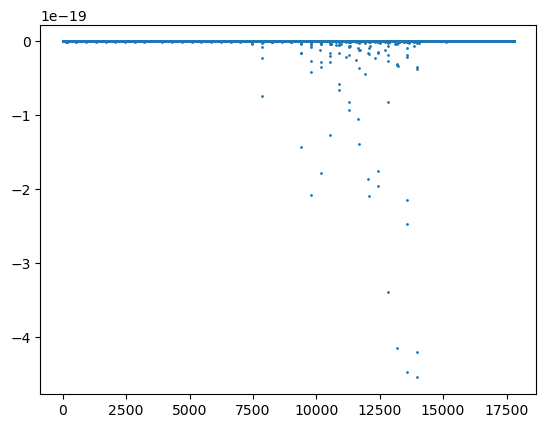

In [21]:
plt.scatter(x=range(0,train.shape[0]), y=train.ptend_q0002_26, s=1)

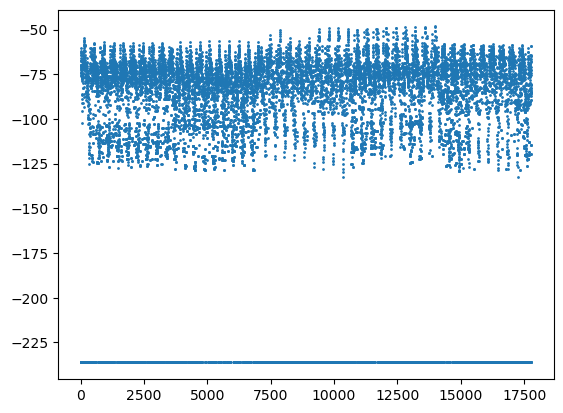

In [22]:
plt.scatter(x=range(0,train.shape[0]), y=train.ptend_q0002_26_transf, s=1)

In [ ]:
precision_info = np.finfo(train[f].dtype.type)

precision = precision_info.precision
precision,precision_info.min

In [ ]:
np.exp(np.log(1e-50)), 1e-50

/var/folders/15/v1vyry112dv3d398dy47k8v40000gn/T/ipykernel_91630/745795689.py:10: RuntimeWarning: divide by zero encountered in log
  y = np.log(abs(x))


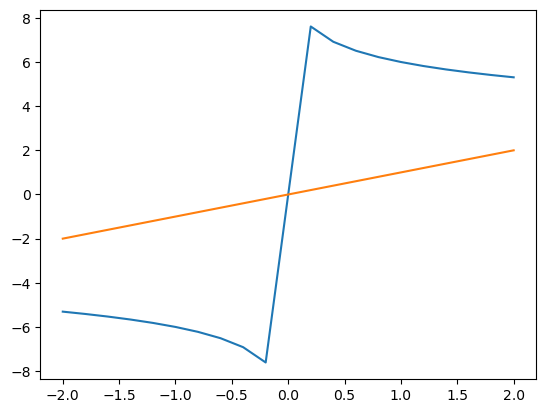

In [20]:
import numpy as np
import matplotlib.pyplot as plt
# attention you loose the sign with this one!!!!
def sech_squared(x,amplitude=10e4,freq=500):
    return np.sign(x)* amplitude / np.cosh(freq*x)
def inverse_sech_squared(y, amplitude=10e4, freq=50):
    return (1 / freq) * np.arccosh(np.sqrt(amplitude / np.abs(y))) * np.sign(y)

def custom_log(x, offset=6):  #offset of works for [-403:403] of x values otherwise sign is lost
    y = np.log(abs(x))
    y[np.isinf(y)] = -1e50  #replace infinities with 0 -> problem, can't learn that after very small x = large y, there should be 0 -> need a different mapping
    y = y - offset           #move curve down such that we have a bigger domain that always has negative values as an outcome [-403:403]
    y = np.sign(x)*abs(y)    #return sign information
    return y

def inv_custom_log(y,offset=6):
    x = np.exp(-abs(y) + offset)
    #x[y == 1e-100] = 0       # not needed since
    x = np.sign(y)*x
    return x

x0 = 0
L = 10
k = 200
x = np.linspace(-2,2,21)
sigmoid = L / (1 + np.exp(-k*(x - x0)))
y = custom_log(x)
inv = inv_custom_log(y)
fig = plt.figure()
plt.plot(x,y)
plt.plot(x,inv)



In [21]:
x

array([-2. , -1.8, -1.6, -1.4, -1.2, -1. , -0.8, -0.6, -0.4, -0.2,  0. ,
        0.2,  0.4,  0.6,  0.8,  1. ,  1.2,  1.4,  1.6,  1.8,  2. ])

## test model

In [25]:
f = 'ptend_q0002_26_transf'
valSet = lgb.Dataset(val[combinedF], label=val[f], free_raw_data=False)
train_set = lgb.Dataset(train[combinedF], train[f], free_raw_data=False)

In [32]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'l2',
    'num_leaves': 15,
    #'learning_rate': 0.05,
    #'feature_fraction': 0.9,
    #'bagging_fraction': 0.8,
    #'bagging_freq': 5,
    'verbose': -1
}


print('processing ',f)
fileName = 'individualLGBMs_feat/model_'+f+'.txt'
gbm = None #lgb.Booster(model_file=fileName) if i != 0 else None

gbm = lgb.train(params,
            train_set,
            num_boost_round=100, 
            valid_sets=valSet,
            init_model=gbm)

predTrain0 = gbm.predict(train[combinedF])
predVal0 = gbm.predict(val[combinedF])
predTrain = inv_custom_log(predTrain0)
predVal = inv_custom_log(predVal0)
r2train =r2_score(inv_custom_log(train[f]), predTrain)
r2test =r2_score(inv_custom_log(val[f]), predVal)
#r2ScoreDict[f][i] = {'train':r2train,'test':r2test}
print('r2 scores', r2train,r2test)
#gbm.save_model(fileName)
#gbm.save_model('individualLGBMs_feat/checkpoints/model_'+f+'_'+str(i)+'_'+str(round(r2test,3))+'.txt')



processing  ptend_q0002_26_transf
r2 scores -3.0108183213917172e-05 -0.00010084526639575486


In [ ]:
# todo: need to predict magnitude and sign separate: by using the log to map the network is able to predict very small changes,
#       but probably will have issues with 0 since they all will have one sign (-) & then the dynamics don't fit together, 
#       a small change in state space = big change in output (- to +) -200 -> + 200
# -> test and evaluate this!!

In [28]:
gbm.best_iteration

0

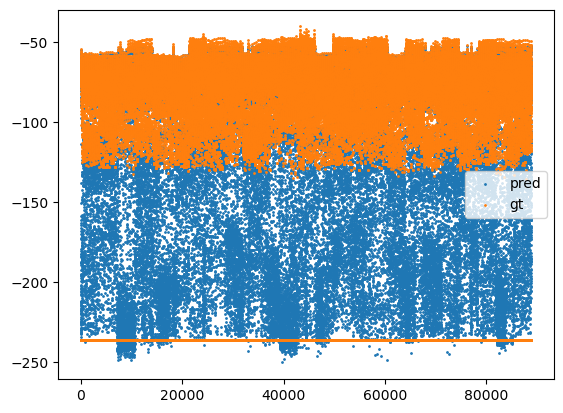

In [33]:
plt.scatter(x=range(predTrain0.shape[0]),y=predTrain0, s=1,label='pred')
plt.scatter(x=range(predTrain0.shape[0]),y=train[f], s=1,label='gt')
plt.legend()
plt.show()

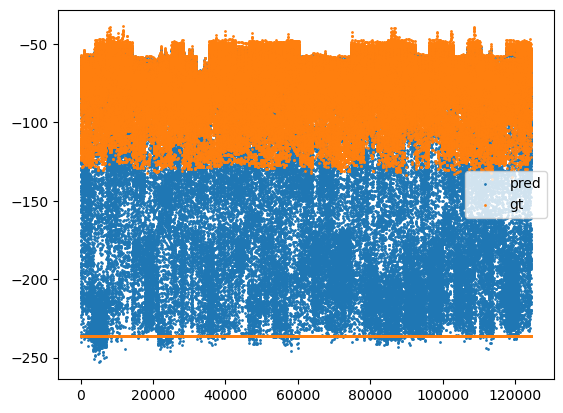

In [34]:
plt.scatter(x=range(predVal0.shape[0]),y=predVal0, s=1,label='pred')
plt.scatter(x=range(predVal0.shape[0]),y=val[f], s=1,label='gt')
plt.legend()
plt.show()

In [ ]:
min(val['ptend_q0002_26']-inv_custom_log(val['ptend_q0002_26_transf']))

In [ ]:
df = pd.DataFrame(predTrain0, columns=['ptend_q0002_26_transf_pred'])
df['ptend_q0002_26_transf'] =train[combinedF]

# baseline

In [ ]:
allTargets = targets60+target1

In [ ]:
mean = np.mean(y, axis=0)
std = np.std(y, axis=0)
std[std==0] = 1

yn = (y - mean) / std
yn_val = (y_val - mean) / std

In [ ]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'l2',
    'num_leaves': 15,
    #'learning_rate': 0.05,
    #'feature_fraction': 0.9,
    #'bagging_fraction': 0.8,
    #'bagging_freq': 5,
    'verbose': -1
}


r2ScoreDict = {f: {} for f in allTargets}
i=0
for idx,f in enumerate(allTargets):
    print('processing ',f)
    fileName = 'individualLGBMs_feat/model_'+f+'.txt'
    gbm = lgb.Booster(model_file=fileName) if i != 0 else None

    valSet = lgb.Dataset(X_val, label=yn_val[:,idx], free_raw_data=False)
    train_set = lgb.Dataset(X, yn[:,idx], free_raw_data=False)
    gbm = lgb.train(params,
                train_set,
                num_boost_round=20, 
                valid_sets=valSet,
                init_model=gbm)
    
    predTrain = gbm.predict(X)
    predVal = gbm.predict(X_val)

    predTrain = predTrain*std[idx] + mean[idx]
    predVal = predVal *std[idx] + mean[idx]
    r2train =r2_score(y[:,idx], predTrain)
    r2test =r2_score(y_val[:,idx], predVal)
    r2ScoreDict[f][i] = {'train':r2train,'test':r2test}
    print('r2 scores', r2train,r2test)
    gbm.save_model(fileName)
    gbm.save_model('individualLGBMs_feat/checkpoints/model_'+f+'_'+str(i)+'_'+str(round(r2test,3))+'.txt')



In [ ]:
# q0002_26 -> outlier removal, seems like there are some cases where it's off
# regenerate plots, index needs to be resetted i guess
# -> better: use exp(targ) to have a better distinguishable target

# MULTIPLY by time! dt = 1200sec, maybe transform to abs value, instead of predicting flux, predict abs value
#e.g. T1 = t0+flux -> flux = (t1-t0)*1200

# try with multiple part